In [1]:
import torch.nn as nn
import torch.nn.functional as F


class ProfileBayesClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_profiles, num_classes,p_y):
        super().__init__()
        self.num_profiles = num_profiles
        self.num_classes = num_classes
        self.p_y = p_y
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_profiles)
        )

        # 使用 register_buffer 保持状态但不被训练
        self.register_buffer("count_z_given_y", torch.zeros(num_profiles, num_classes))  # [T, K]

    def update_profile_counts(self, q_z_given_x, y_true):
        """
        使用 soft assignment 更新 profile 频数表：
        q_z_given_x: [B, T], y_true: [B]
        """
        with torch.no_grad():
            B, T = q_z_given_x.shape
            K = self.num_classes
            one_hot_y = F.one_hot(y_true, K).float()  # [B, K]
            # outer product: for each sample, update count[z, y]
            # Resulting shape: [B, T, K]
            contrib = torch.einsum("bt,bk->btk", q_z_given_x, one_hot_y)
            self.count_z_given_y += contrib.sum(dim=0)  # sum over batch

    def compute_p_z_given_y(self):
        # 避免除以 0：加入平滑
        smoothed = self.count_z_given_y + 1e-3
        return smoothed / smoothed.sum(dim=0, keepdim=True)  # [T, K]



    def forward(self, x):
        # q(Z|X)
        profile_logits = self.encoder(x)
        q_z_given_x = F.softmax(profile_logits, dim=1)  # [B, T]

        # Profile 后验
        p_z_given_y = self.compute_p_z_given_y()  # [T, K]

        # 归一化（每行归一）
        p_z = (p_z_given_y * self.p_y.unsqueeze(0)).sum(dim=1)  # shape [T]

        # 构造完整贝叶斯项：P(Z|Y)*P(Y) / P(Z)
        bayes_matrix = (p_z_given_y * self.p_y.unsqueeze(0)) / (p_z.unsqueeze(1) + 1e-9)  # [T, K]

        # 推理公式：P(Y|X) = sum_z P(Y|Z=z) * P(Z=z|X)
        p_y_given_x = q_z_given_x @ bayes_matrix  # shape [B, K]
        return p_y_given_x, q_z_given_x, p_z_given_y

    def predict(self, x):
        p_y_given_x, _, _ = self.forward(x)
        return p_y_given_x

def profile_entropy_regularization(q_z_given_x):
        avg_profile = q_z_given_x.mean(dim=0) + 1e-9
        return -torch.sum(avg_profile * avg_profile.log())

def profile_kl_regularization(q_z_given_x):
    avg_profile = q_z_given_x.mean(dim=0) + 1e-9
    log_avg = avg_profile.log()
    log_uniform = torch.full_like(log_avg, fill_value=torch.log(torch.tensor(1.0 / len(avg_profile))))
    return torch.sum(avg_profile * (log_avg - log_uniform))


import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class GenerativeProfileBayesClassifier(nn.Module):
    def __init__(self, input_dim, num_profiles, num_classes):
        """
        input_dim: X 的维度
        num_profiles: 潜在 profile 数 (T)
        num_classes: 类别数 (K)
        """
        super().__init__()
        self.num_profiles = num_profiles
        self.num_classes = num_classes

        # p(Z) 先验 (Categorical 分布)
        self.logits_pz = nn.Parameter(torch.zeros(num_profiles))  # [T]

        # p(X|Z) = Gaussian(mu_z, diag(sigma^2_z))
        self.mu = nn.Parameter(torch.randn(num_profiles, input_dim))  # [T, D]
        self.logvar = nn.Parameter(torch.zeros(num_profiles, input_dim))  # [T, D]

        # p(Y|Z) = Categorical
        self.logits_y_given_z = nn.Parameter(torch.zeros(num_profiles, num_classes))  # [T, K]

    def p_x_given_z(self, x):
        """
        计算 p(x|z) for all z
        x: [B, D], mu/logvar: [T, D]
        return: [B, T]
        """
        B, D = x.shape
        x_expand = x.unsqueeze(1)  # [B, 1, D]
        mu = self.mu.unsqueeze(0)  # [1, T, D]
        logvar = self.logvar.unsqueeze(0)  # [1, T, D]
        var = logvar.exp()

        log_prob = -0.5 * (((x_expand - mu) ** 2) / var + logvar + math.log(2 * math.pi)).sum(dim=2)
        return log_prob.exp()  # [B, T]

    def forward(self, x):
        """
        返回:
          p_y_given_x: [B, K]
          p_z_given_x: [B, T]
        """
        B = x.size(0)

        # p(z) = softmax(logits_pz)
        p_z = F.softmax(self.logits_pz, dim=0)  # [T]

        # p(x|z)
        p_x_given_z = self.p_x_given_z(x)  # [B, T]

        # p(z|x) ∝ p(x|z) p(z)
        log_posterior = torch.log(p_x_given_z + 1e-9) + torch.log(p_z.unsqueeze(0) + 1e-9)  # [B, T]
        p_z_given_x = F.softmax(log_posterior, dim=1)  # [B, T]

        # p(y|z)
        p_y_given_z = F.softmax(self.logits_y_given_z, dim=1)  # [T, K]

        # p(y|x) = ∑_z p(y|z) p(z|x)
        p_y_given_x = p_z_given_x @ p_y_given_z  # [B, K]

        return p_y_given_x, p_z_given_x, p_y_given_z

    def predict(self, x):
        p_y_given_x, _, _ = self.forward(x)
        return p_y_given_x

    def generate(self, num_samples=10):
        """
        生成样本 (x, y)
        """
        with torch.no_grad():
            # 1. 采样 z ~ p(z)
            p_z = F.softmax(self.logits_pz, dim=0)
            z = torch.multinomial(p_z, num_samples=num_samples, replacement=True)  # [N]

            # 2. 采样 x ~ p(x|z)
            mu = self.mu[z]       # [N, D]
            logvar = self.logvar[z]
            std = (0.5 * logvar).exp()
            eps = torch.randn_like(std)
            x = mu + eps * std

            # 3. 采样 y ~ p(y|z)
            p_y_given_z = F.softmax(self.logits_y_given_z[z], dim=1)  # [N, K]
            y = torch.multinomial(p_y_given_z, num_samples=1).squeeze(1)  # [N]

            return x, y, z


In [2]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from dbc.utils import compute_conditional_risk

def make_preprocessor(X):
    num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features)
        ]
    )
    return preprocessor

def global_risk(y_true, y_pred):
    return np.mean(y_true != y_pred)

def max_gap(y_true, y_pred):
    R = compute_conditional_risk(y_true, y_pred)[0]
    return np.max(R) - np.min(R)

def max_Rk(y_true, y_pred):
    R = compute_conditional_risk(y_true, y_pred)[0]
    return np.max(R)


In [168]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

# df = fetch_ucirepo(id=17)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=15)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=53)  # IRIS
# df = fetch_ucirepo(id=186)  # Wine quality
# df = fetch_ucirepo(id=2)  # Adult
# df = fetch_ucirepo(id=222)  # Bank Marketing
df = fetch_ucirepo(id=19)  # Car Evaluation(表现很差)
# df = fetch_ucirepo(id=73)  # Mushroom
# df = fetch_ucirepo(id=59)  # Letter Recognition(不知道为什么这个数据集DMC和SPDMC效果很差,难道是分类类别过多导致的？)
# df = fetch_ucirepo(id=149)  # Statlog (Vehicle Silhouettes)(如果SPDMC不收敛记得移除类别只有1个的)

X = df.data.features.replace("?", np.nan)  # Only for adult

X = df.data.features
X = make_preprocessor(X).fit_transform(X)
y = df.data.targets.values.ravel()

# Onlu for Statlog
mask = y != '204'
X = X.iloc[mask] if hasattr(X, 'iloc') else X[mask]
y = y[mask]

y = LabelEncoder().fit_transform(y)
np.bincount(y)

array([ 384,   69, 1210,   65])

In [169]:
from sklearn.model_selection import train_test_split

# 分训练集与验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [170]:

from dbc.main import KmeansDiscreteBayesianClassifier, DecisionTreeDiscreteBayesianClassifier, KmeansDiscreteMinmaxClassifier, CmeansDiscreteMinmaxClassifier
from dbc.utils import compute_conditional_risk
from sklearn.metrics import accuracy_score

DBC_kmeans = KmeansDiscreteBayesianClassifier(n_clusters=40)
DBC_kmeans.fit(X_train, y_train)
y_pred = DBC_kmeans.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'Kmeans Class condition risk: \n{conditional_risk[0]}')
print(f'\nKmeans Acc: \n{accuracy_score(y_val, y_pred)}')

Kmeans Class condition risk: 
[0.19626168 1.         0.1462766  1.        ]

Kmeans Acc: 
0.7842003853564548


In [171]:
DBC_DT = DecisionTreeDiscreteBayesianClassifier(max_depth=3)
DBC_DT.fit(X_train, y_train)
y_pred = DBC_DT.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'DT Class condition risk: \n{conditional_risk[0]}')
print(f'\nDT Acc: \n{accuracy_score(y_val, y_pred)}')

DT Class condition risk: 
[0.24299065 1.         0.11170213 1.        ]

DT Acc: 
0.7996146435452793


In [172]:
SPDMC = CmeansDiscreteMinmaxClassifier(n_clusters=40,fuzzifier=1.05)
SPDMC.fit(X_train, y_train)
y_pred = SPDMC.predict(X_val)
conditional_risk = compute_conditional_risk(y_val, y_pred)
print(f'Kmeans Class condition risk: \n{conditional_risk[0]}')
print(f'\nKmeans Acc: \n{accuracy_score(y_val, y_pred)}')

Kmeans Class condition risk: 
[0.53271028 0.52941176 0.44946809 0.63157895]

Kmeans Acc: 
0.5240847784200385


In [173]:
from dbc.utils import compute_prior
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
p_y = torch.tensor(compute_prior(y_train, num_classes), dtype=torch.float32)

# 转成 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

Epoch   1: Train Loss=11.4129, Val Loss=5.6132 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   2: Train Loss=11.4172, Val Loss=5.6132 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   3: Train Loss=11.4258, Val Loss=5.6132 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   4: Train Loss=11.4185, Val Loss=5.6131 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   5: Train Loss=11.4445, Val Loss=5.6130 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   6: Train Loss=11.4440, Val Loss=5.6121 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   7: Train Loss=11.3892, Val Loss=5.6064 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   8: Train Loss=11.3972, Val Loss=5.5735 | Train Acc=0.6898 | Val Acc=0.7245
Epoch   9: Train Loss=11.3013, Val Loss=5.4866 | Train Acc=0.6898 | Val Acc=0.7245
Epoch  10: Train Loss=11.1516, Val Loss=5.3771 | Train Acc=0.6898 | Val Acc=0.7245
Epoch  11: Train Loss=10.9144, Val Loss=5.2693 | Train Acc=0.6898 | Val Acc=0.7245
Epoch  12: Train Loss=10.7530, Val Loss=5.1808 | Train Acc=0.6898 | Val Acc=0.7245
Epoc

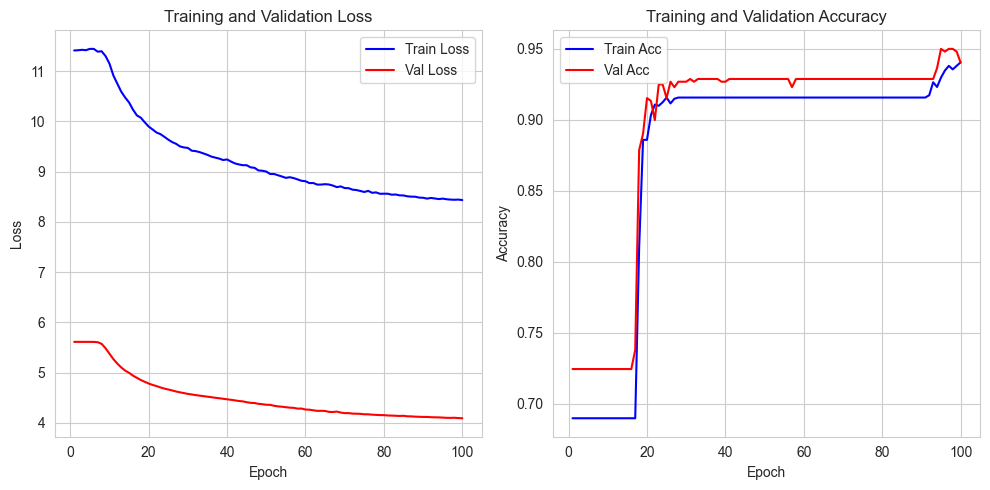

In [174]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


input_dim = X_train.shape[1]
hidden_dim = 64
num_profiles = 40
num_classes = len(np.unique(y_train))

model = ProfileBayesClassifier(input_dim, hidden_dim, num_profiles, num_classes,p_y)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


num_epochs = 100
train_losses = []
val_losses = []  # 添加验证损失列表
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        p_y_given_x, q_z_given_x, _ = model(X_batch)
        model.update_profile_counts(q_z_given_x, y_batch)
        loss = criterion(p_y_given_x, y_batch) + 0.1 * profile_kl_regularization(q_z_given_x)
        loss.backward()
        optimizer.step()
        train_total_loss += loss.item()

        train_preds = torch.argmax(p_y_given_x, dim=1)
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_losses.append(train_total_loss)
    train_accuracies.append(train_correct / train_total)

    # 验证阶段
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            p_y_given_x = model.predict(X_batch)
            val_loss = criterion(p_y_given_x, y_batch)
            val_total_loss += val_loss.item()

            correct += (torch.argmax(p_y_given_x, dim=1) == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_total_loss)
    acc = correct / total
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1:3d}: Train Loss={train_total_loss:.4f}, Val Loss={val_total_loss:.4f} | Train Acc={train_accuracies[-1]:.4f} | Val Acc={acc:.4f}")

# 绘制训练和验证损失
plt.figure(figsize=(10, 5))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [175]:
SPDMC.membership_degree = model(X_train)[1].detach().numpy().T
membership_degree_pred = model(X_val)[1].detach().numpy().T
from dbc.utils import compute_b_risk, compute_p_hat_with_degree
p_hat = compute_p_hat_with_degree(SPDMC.membership_degree,y_train,num_classes)


y_pred = np.argmin(compute_b_risk(membership_degree_pred, p_hat, SPDMC.prior,SPDMC.loss_function),axis=1)

conditional_risk = compute_conditional_risk(y_val.numpy(), y_pred)
print(f'discriminative SPDBC condition risk: \n{conditional_risk[0]}')
print(f'\nAcc: \n{accuracy_score(y_val, y_pred)}')

discriminative SPDBC condition risk: 
[0.00934579 0.05882353 0.00265957 0.36842105]

Acc: 
0.9807321772639692


In [176]:
SPDMC.membership_degree = model(X_train)[1].detach().numpy().T
membership_degree_pred = model(X_val)[1].detach().numpy().T
from dbc.utils import compute_SPDBC_pi_star
SPDMC.pi_star = compute_SPDBC_pi_star(X_train.numpy(), y_train.numpy(), SPDMC.loss_function, p_hat, SPDMC.membership_degree, SPDMC.prior,alpha=1,beta=0.8,n_iter=1000)

y_pred = np.argmin(compute_b_risk(SPDMC.membership_degree, p_hat, SPDMC.pi_star,SPDMC.loss_function),axis=1)

conditional_risk = compute_conditional_risk(y_train.numpy(), y_pred)
print(f'discriminative SPDMC condition risk: \n{conditional_risk[0]}')
print(f'\nAcc: \n{accuracy_score(y_train, y_pred)}')

discriminative SPDMC condition risk: 
[0.27436823 0.26923077 0.00479616 0.26086957]

Acc: 
0.91232423490488


In [177]:
SPDMC.pi_star

array([2.08150206e-03, 4.90250281e-01, 5.91432527e-05, 5.07609074e-01])

In [178]:
# SPDMC.membership_degree = model(X_train)[1].detach().numpy().T
# membership_degree_pred = model(X_val)[1].detach().numpy().T
# from dbc.utils import compute_SPDBC_pi_star
# SPDMC.pi_star = compute_SPDBC_pi_star(X_train.numpy(), y_train.numpy(), SPDMC.loss_function, p_hat, SPDMC.membership_degree, SPDMC.prior,alpha=1,beta=0.8,n_iter=1000)

y_pred = np.argmin(compute_b_risk(membership_degree_pred, p_hat, SPDMC.pi_star,SPDMC.loss_function),axis=1)

conditional_risk = compute_conditional_risk(y_val.numpy(), y_pred)
print(f'discriminative SPDMC condition risk: \n{conditional_risk[0]}')
print(f'\nAcc: \n{accuracy_score(y_val, y_pred)}')

discriminative SPDMC condition risk: 
[0.3271028  0.35294118 0.0106383  0.36842105]

Acc: 
0.8998073217726397


Epoch   1: Train Loss=366.9609, Val Loss=155.4231 | Train Acc=0.5043 | Val Acc=0.5086
Epoch   2: Train Loss=357.6392, Val Loss=151.4749 | Train Acc=0.5051 | Val Acc=0.5086
Epoch   3: Train Loss=349.4148, Val Loss=148.3420 | Train Acc=0.5051 | Val Acc=0.5086
Epoch   4: Train Loss=343.4763, Val Loss=146.2654 | Train Acc=0.5051 | Val Acc=0.5086
Epoch   5: Train Loss=339.7363, Val Loss=144.9650 | Train Acc=0.5051 | Val Acc=0.5086
Epoch   6: Train Loss=337.4363, Val Loss=144.1505 | Train Acc=0.5051 | Val Acc=0.5086
Epoch   7: Train Loss=335.9410, Val Loss=143.6100 | Train Acc=0.5051 | Val Acc=0.5086
Epoch   8: Train Loss=334.9955, Val Loss=143.2439 | Train Acc=0.5051 | Val Acc=0.5086
Epoch   9: Train Loss=334.0820, Val Loss=142.9807 | Train Acc=0.5051 | Val Acc=0.5086
Epoch  10: Train Loss=333.7412, Val Loss=142.7842 | Train Acc=0.5051 | Val Acc=0.5086
Epoch  11: Train Loss=333.3571, Val Loss=142.6355 | Train Acc=0.5051 | Val Acc=0.5086
Epoch  12: Train Loss=333.0112, Val Loss=142.5193 | Tr

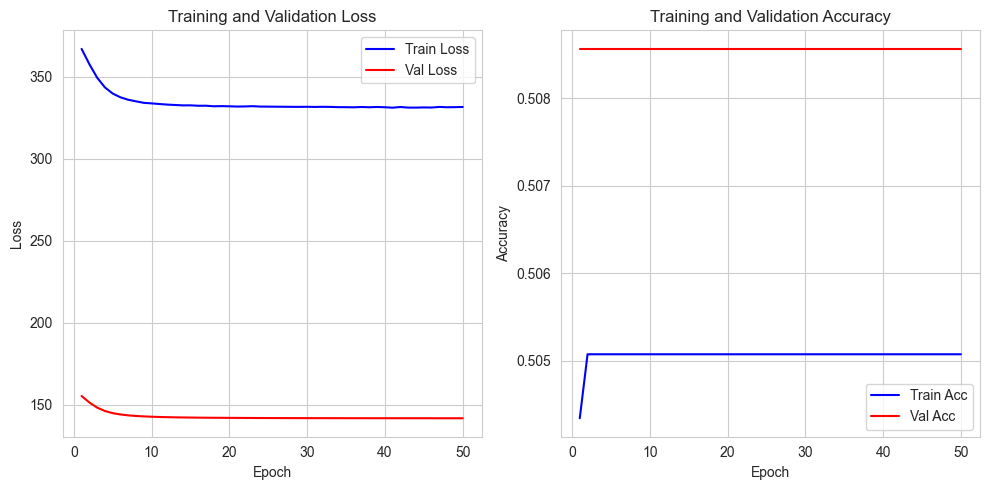

In [165]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_profiles = 20

# 用生成式版本
model = GenerativeProfileBayesClassifier(input_dim, num_profiles, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_total_loss = 0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        p_y_given_x, p_z_given_x, p_y_given_z = model(X_batch)

        loss = criterion(p_y_given_x, y_batch)  # 分类损失
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        train_preds = torch.argmax(p_y_given_x, dim=1)
        train_correct += (train_preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_losses.append(train_total_loss)
    train_accuracies.append(train_correct / train_total)

    # 验证阶段
    model.eval()
    val_total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            p_y_given_x, _, _ = model(X_batch)
            val_loss = criterion(p_y_given_x, y_batch)
            val_total_loss += val_loss.item()

            preds = torch.argmax(p_y_given_x, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_total_loss)
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1:3d}: "
          f"Train Loss={train_total_loss:.4f}, Val Loss={val_total_loss:.4f} | "
          f"Train Acc={train_accuracies[-1]:.4f} | Val Acc={val_accuracies[-1]:.4f}")

# 绘制训练和验证曲线
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [166]:
SPDMC.membership_degree = model(X_train)[1].detach().numpy().T
membership_degree_pred = model(X_val)[1].detach().numpy().T
from dbc.utils import compute_b_risk, compute_p_hat_with_degree
p_hat = compute_p_hat_with_degree(SPDMC.membership_degree,y_train,num_classes)


y_pred = np.argmin(compute_b_risk(membership_degree_pred, p_hat, SPDMC.prior,SPDMC.loss_function),axis=1)

conditional_risk = compute_conditional_risk(y_val.numpy(), y_pred)
print(f'Kmeans Class condition risk: \n{conditional_risk[0]}')
print(f'\nKmeans Acc: \n{accuracy_score(y_val, y_pred)}')

Kmeans Class condition risk: 
[0. 1. 1. 1.]

Kmeans Acc: 
0.508564799017266


In [167]:
SPDMC.membership_degree = model(X_train)[1].detach().numpy().T
membership_degree_pred = model(X_val)[1].detach().numpy().T
from dbc.utils import compute_SPDBC_pi_star
SPDMC.pi_star = compute_SPDBC_pi_star(X_train.numpy(), y_train.numpy(), SPDMC.loss_function, p_hat, SPDMC.membership_degree, SPDMC.prior,alpha=1,beta=0.8,n_iter=1000)

y_pred = np.argmin(compute_b_risk(SPDMC.membership_degree, p_hat, SPDMC.pi_star,SPDMC.loss_function),axis=1)

conditional_risk = compute_conditional_risk(y_train.numpy(), y_pred)
print(f'Kmeans Class condition risk: \n{conditional_risk[0]}')
print(f'\nKmeans Acc: \n{accuracy_score(y_train, y_pred)}')

Kmeans Class condition risk: 
[1. 1. 1. 0.]

Kmeans Acc: 
0.0784170347187692


In [151]:
SPDMC.pi_star

array([0.34509793, 0.30696167, 0.04090664, 0.30703376])